<h2>KNN Model<h2>

In [1]:
#import packages

import sys
print(sys.executable)

import skimage
print(skimage.__version__)

import os
import cv2

#from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops


c:\Users\xfaan\Documents\GitHub\is460-project\myenv\Scripts\python.exe
0.22.0


<h2> Data Pre-processing <h2>

In [2]:
# Load and Preprocess Data
DATA_SPLIT = 'train' 
DATA_DIR = os.path.join("chest_xray", DATA_SPLIT)
CATEGORIES = ["NORMAL", "PNEUMONIA"]

data = []

labels = []

for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_array = cv2.resize(img_array, (150, 150))
        data.append(resized_array)
        labels.append(category)


Texture-based Feature Extraction

In [3]:
# Texture-based Feature Extraction

def compute_texture_features(image):
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

# Extract texture features
texture_features = [compute_texture_features(image) for image in data]


Dimensionality Reduction using PCA

In [4]:
# Dimensionality Reduction using PCA - Flatten the data and apply PCA

data_flat = [img.flatten() for img in data]
data_combined = [np.hstack((data_flat[i], texture_features[i])) for i in range(len(data_flat))]

pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_combined)


Data Augmentation

In [5]:
# Data Augmentation
augment = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

augmented_data = []
augmented_labels = []

for image, label in zip(data, labels):
    image = image.reshape(1, 150, 150, 1)
    for x_batch in augment.flow(image, batch_size=1):
        augmented_data.append(x_batch.reshape(150, 150))
        augmented_labels.append(label)
        if len(augmented_data) % 5 == 0:  # for example, generate 5 augmented versions per image
            break


<h2>Training KNN Model<h2>

In [6]:
# Train KNN Model and find the best k value

from sklearn.model_selection import train_test_split

X = np.array(augmented_data).reshape(-1, 150*150)
y = np.array(augmented_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Finding the best k
accuracy_list = []
training_accuracy_list = [] # To store training accuracies

for k in range(1, 21):  # checking k from 1 to 20
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_accuracy = knn.score(X_test, y_test)
    train_accuracy = knn.score(X_train, y_train)  # Evaluating accuracy on training data
    accuracy_list.append(test_accuracy)
    training_accuracy_list.append(train_accuracy)  # Storing training accuracy

best_k = accuracy_list.index(max(accuracy_list)) + 1


<h2> Metrics <h2>

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

positive_label = 'PNEUMONIA'

# Metrics for Training Data
y_pred_train = knn.predict(X_train)  

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, pos_label=positive_label)
recall_train = recall_score(y_train, y_pred_train, pos_label=positive_label)
f1_train = f1_score(y_train, y_pred_train, pos_label=positive_label)

print('--Metrics for Training Data--')
print('Accuracy_test:', round(accuracy_train,4))
print('Precision_test:', round(precision_train,4))
print('Recall_test:', round(recall_train,4))
print('F1 Score_test:', round(f1_train,4))


print('\n')
# Metrics for Testing Data

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=positive_label)
recall = recall_score(y_test, y_pred, pos_label=positive_label)
f1 = f1_score(y_test, y_pred, pos_label=positive_label)

print('--Metrics for Testing Data--')
print('Accuracy:', round(accuracy,4))
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:', round(f1,4))



--Metrics for Training Data--
Accuracy_test: 0.9459
Precision_test: 0.9512
Recall_test: 0.9774
F1 Score_test: 0.9641


--Metrics for Testing Data--
Accuracy: 0.9032
Precision: 0.9111
Recall: 0.9632
F1 Score: 0.9364


<h2>K vs. Accuracy Graph:<h2>

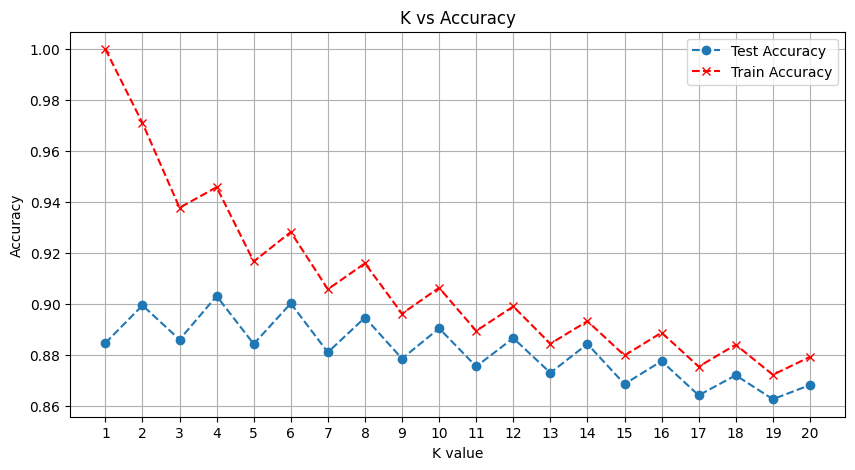

In [18]:
# Visualizing the accuracy for different values of k
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracy_list, marker='o', linestyle='dashed', label='Test Accuracy')
plt.plot(range(1, 21), training_accuracy_list, marker='x', linestyle='dashed', label='Train Accuracy', color='r')  # plotting training accuracy
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()


